In [ ]:
#@title Mount Google Drive {display-mode: "form"}

# This code will be hidden when the notebook is loaded.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

# Setting random seeds to reduce the amount of randomness in the neural net weights and results
# The results may still not be exactly reproducible

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#@title Check for GPU

# Testing to ensure GPU is being utilized
# Ensure that the Runtime Type for this notebook is set to GPU
# If a GPU device is not found, change the runtime type under: Runtime>> Change runtime type>> Hardware accelerator>> GPU
# and run the notebook from the beginning again.

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Import Dataset

In [ ]:
# Unzipping the dataset file combined_faces.zip

combined_faces_zip_path = "/content/drive/MyDrive/dataset_agee/Copy of combined_faces.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces.zip')

Done unzipping combined_faces.zip


In [ ]:
# Unzipping the dataset file combined_faces.zip

combined_faces_zip_path = "/content/drive/MyDrive/dataset_agee/Copy of combined_faces_train_augmented.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces_train_augmented.zip')

Done unzipping combined_faces_train_augmented.zip


In [ ]:
# Importing the augmented training dataset and testing dataset to create tensors of images using the filename paths.

train_aug_df = pd.read_csv("/content/drive/MyDrive/dataset_agee/Copy of images_filenames_labels_train_augmented.csv")
test_df = pd.read_csv("/content/drive/MyDrive/dataset_agee/Copy of images_filenames_labels_test.csv")

In [ ]:
train_aug_df.head()

,filename,age
0,/content/content/combined_faces_train_augmente...,43
1,/content/content/combined_faces_train_augmente...,71
2,/content/content/combined_faces_train_augmente...,6
3,/content/content/combined_faces_train_augmente...,18
4,/content/content/combined_faces_train_augmente...,25


In [ ]:
test_df.head()

,filename,age
0,/content/content/combined_faces/8_163.jpg,8
1,/content/content/combined_faces/38_66.jpg,38
2,/content/content/combined_faces/40_177.jpg,40
3,/content/content/combined_faces/36_267.jpg,36
4,/content/content/combined_faces/8_349.jpg,8


In [ ]:
train_aug_df.shape

(234400, 2)

In [ ]:
test_df.shape

(10046, 2)

In [ ]:
# Defining a function to return the class labels corresponding to the re-distributed 7 age-ranges.

def class_labels_reassign(age):

    if 0 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 35:
        return 4
    elif 36 <= age <= 45:
        return 5
    elif 46 <= age <= 55:
        return 6
    elif 56 <= age <= 65:
        return 7
    else:
        return 8

In [ ]:
train_aug_df['target'] = train_aug_df['age'].map(class_labels_reassign)
test_df['target'] = test_df['age'].map(class_labels_reassign)

In [ ]:
train_aug_df.head()

,filename,age,target
0,/content/content/combined_faces_train_augmente...,43,5
1,/content/content/combined_faces_train_augmente...,71,8
2,/content/content/combined_faces_train_augmente...,6,1
3,/content/content/combined_faces_train_augmente...,18,2
4,/content/content/combined_faces_train_augmente...,25,3


In [ ]:
test_df.head()

,filename,age,target
0,/content/content/combined_faces/8_163.jpg,8,1
1,/content/content/combined_faces/38_66.jpg,38,5
2,/content/content/combined_faces/40_177.jpg,40,5
3,/content/content/combined_faces/36_267.jpg,36,5
4,/content/content/combined_faces/8_349.jpg,8,1


In [ ]:
# Converting the filenames and target class labels into lists for augmented train and test datasets.

train_aug_filenames_list = list(train_aug_df['filename'])
train_aug_labels_list = list(train_aug_df['target'])

test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target'])

In [ ]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_aug_filenames_tensor = tf.constant(train_aug_filenames_list)
train_aug_labels_tensor = tf.constant(train_aug_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

# Image Greyscale Function

In [ ]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 9

def _parse_function(filename, label):

    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_aug_dataset = train_aug_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

# CNN Architecture

In [ ]:
# Defining the architecture of the sequential neural network.

final_cnn = Sequential()

# Input layer with 16 filters, followed by an AveragePooling2D layer.
final_cnn.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

# Five Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=512, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=1024, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
final_cnn.add(GlobalAveragePooling2D())

# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
final_cnn.add(Dense(132, activation='relu'))

# Output layer with 9 nodes (equal to the no. of classes).
final_cnn.add(Dense(9, activation='softmax'))

final_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      160       
                                                                 
 average_pooling2d (Average  (None, 99, 99, 16)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        9280      
                                                                 
 average_pooling2d_1 (Avera  (None, 48, 48, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_2 (Avera  (None, 23, 23, 128)       0

In [ ]:
# Compiling the above created CNN architecture.

final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Creating a TensorBoard callback object and saving it at the desired location.

tensorboard = TensorBoard(log_dir=f"/content/drive/MyDrive/dataset_agee/output")

In [ ]:
# Creating a ModelCheckpoint callback object to save the model according to the value of val_accuracy.

checkpoint = ModelCheckpoint(filepath=f"/content/drive/MyDrive/dataset_agee/output/final_cnn_history.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

In [ ]:
# Fitting the above created CNN model.

final_cnn_history = final_cnn.fit(train_aug_dataset,
                                  batch_size=512,
                                  validation_data=test_dataset,
                                  epochs=12,
                                  callbacks=[tensorboard, checkpoint],
                                  shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                                 )

Epoch 1/12
458/458 [==============================] - ETA: 0s - loss: 1.8987 - accuracy: 0.3287
Epoch 1: val_accuracy improved from -inf to 0.37975, saving model to /content/drive/MyDrive/dataset_agee/output/final_cnn_history.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


458/458 [==============================] - 320s 633ms/step - loss: 1.8987 - accuracy: 0.3287 - val_loss: 1.5471 - val_accuracy: 0.3798
Epoch 2/12
458/458 [==============================] - ETA: 0s - loss: 1.2989 - accuracy: 0.4756
Epoch 2: val_accuracy improved from 0.37975 to 0.51035, saving model to /content/drive/MyDrive/dataset_agee/output/final_cnn_history.h5
458/458 [==============================] - 221s 481ms/step - loss: 1.2989 - accuracy: 0.4756 - val_loss: 1.1900 - val_accuracy: 0.5104
Epoch 3/12
458/458 [==============================] - ETA: 0s - loss: 1.1178 - accuracy: 0.5372
Epoch 3: val_accuracy improved from 0.51035 to 0.55574, saving model to /content/drive/MyDrive/dataset_agee/output/final_cnn_history.h5
458/458 [==============================] - 222s 483ms/step - loss: 1.1178 - accuracy: 0.5372 - val_loss: 1.0837 - val_accuracy: 0.5557
Epoch 4/12
458/458 [==============================] - ETA: 0s - loss: 1.0111 - accuracy: 0.5807
Epoch 4: val_accuracy improved from

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = final_cnn_history.history['loss']
test_loss = final_cnn_history.history['val_loss']
train_accuracy = final_cnn_history.history['accuracy']
test_accuracy = final_cnn_history.history['val_accuracy']

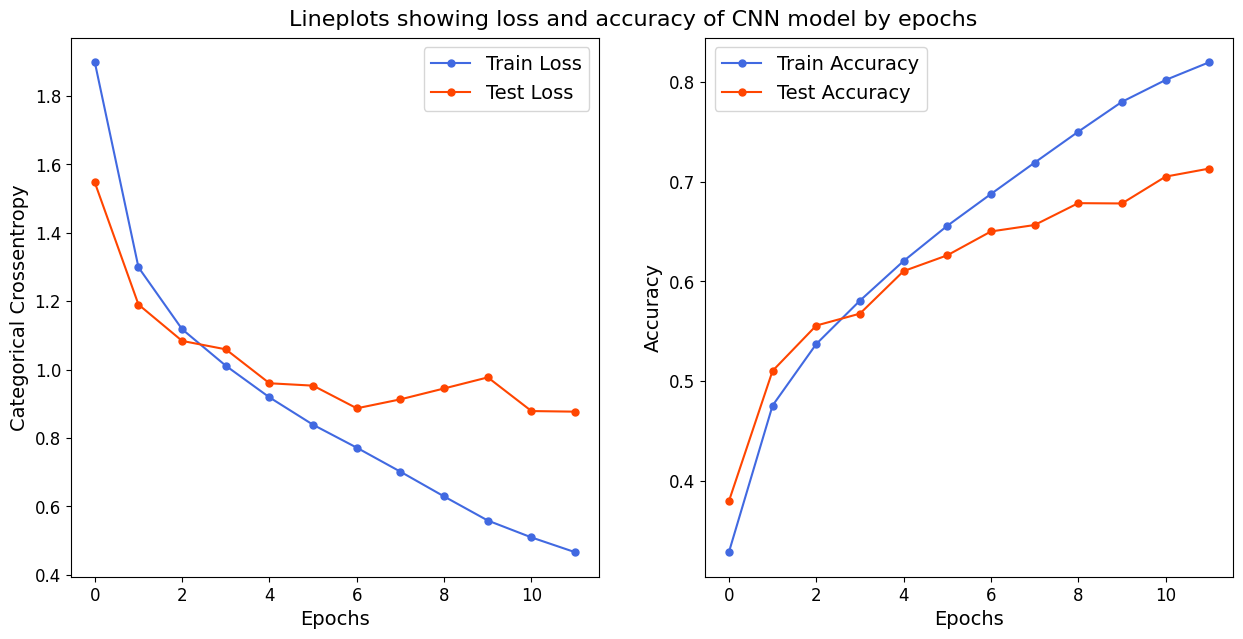

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/MyDrive/dataset_agee/output/cnn_logs', bbox_inches='tight');

In [ ]:
# Evaluating the model on test dataset.

final_cnn_score = final_cnn.evaluate(test_dataset, verbose=1)

20/20 [==============================] - 22s 632ms/step - loss: 3.3116 - accuracy: 0.0805


In [ ]:
# Printing the relevant score summary.

final_cnn_labels = final_cnn.metrics_names
print(f'CNN model {final_cnn_labels[0]} \t\t= {round(final_cnn_score[0], 3)}')
print(f'CNN model {final_cnn_labels[1]} \t= {round(final_cnn_score[1], 3)}')

CNN model loss 		= 3.312
CNN model accuracy 	= 0.081


In [ ]:
# Saving the model as a h5 file for possible use later.

final_cnn.save(f"/content/drive/MyDrive/dataset_agee/output/final_cnn_history.h5", save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Plotting Confusion Matrix

In [ ]:
# Generating predictions from the model above.

final_cnn_pred = final_cnn.predict(test_dataset)
final_cnn_pred = final_cnn_pred.argmax(axis=-1)

20/20 [==============================] - 2s 114ms/step


In [ ]:
# Generating a confusion matrix based on above predictions.

conf_mat = confusion_matrix(test_labels_list, final_cnn_pred)
conf_mat

array([[   1,    1,    0,    0,    0,    0,    0,    0,  956],
       [   0,    0,    0,    0,    0,    0,    0,    0,  845],
       [   0,    0,    0,    0,    0,    0,    0,    0,  941],
       [   2,    1,    0,    0,    0,    0,    0,    1, 2003],
       [   3,    1,    0,    0,    0,    0,    0,    0, 1666],
       [   1,    1,    0,    0,    0,    0,    0,    0, 1135],
       [   0,    2,    0,    0,    0,    0,    0,    0,  944],
       [   0,    2,    0,    0,    0,    0,    0,    0,  731],
       [   0,    1,    0,    0,    0,    0,    0,    0,  808]])

In [ ]:
# Defining a function to plot the confusion matrix in a grid for easier visualization.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    plt.savefig(f'/content/drive/MyDrive/dataset_agee/output/cnn_logs', bbox_inches='tight');

Normalized confusion matrix


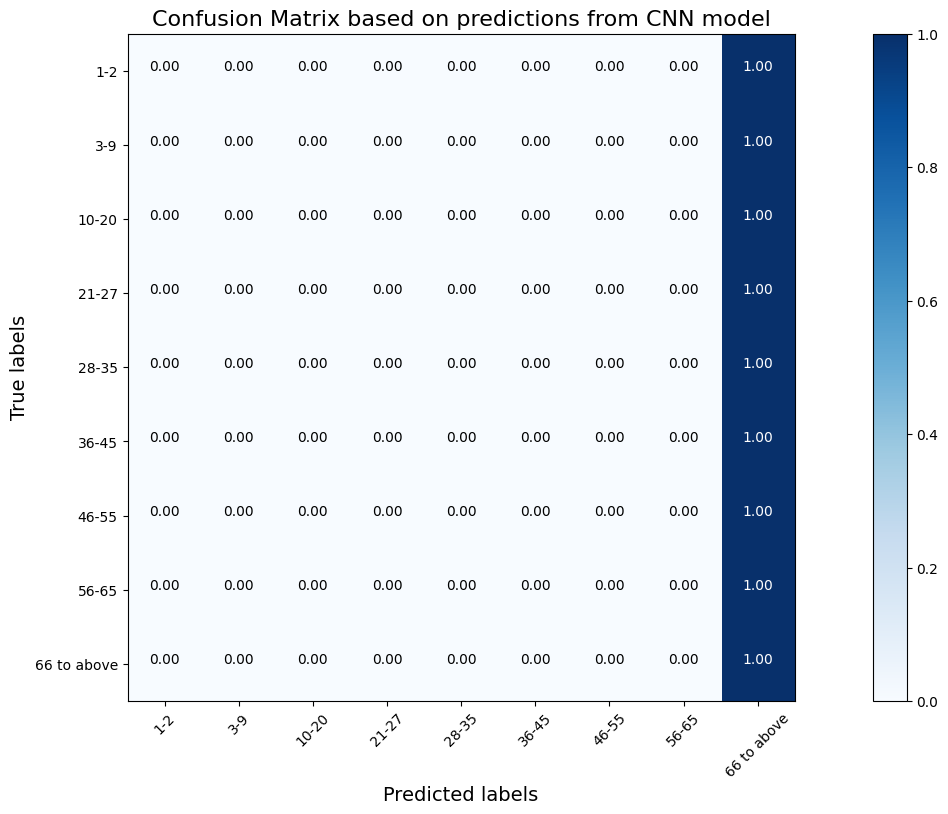

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = ['1-2','3-9','10-20','21-27','28-35','36-45','46-55','56-65','66 to above']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )

plt.show()

In [ ]:
from keras.models import load_model
from PIL import Image
import numpy as np
import cv2

#the following are to do with this interactive notebook code

%matplotlib inline
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
import pylab # this allows you to control figure size
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # this controls figure size in the notebook


In [ ]:
export_dir='/content/drive/MyDrive/dataset_agee'
age_model = load_model(export_dir)

# summarize model.
age_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 average_pooling2d (Average  (None, 99, 99, 32)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_1 (Avera  (None, 48, 48, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_2 (Avera  (None, 23, 23, 128)       0

In [ ]:
age_ranges = ['1-2','3-9','10-20','','21-27','28-35','36-45','46-55','56-65','66 to above']
img_path = "/content/drive/MyDrive/dataset_agee/assets/dataset_test.jpg"

1/1 [==============================] - 0s 477ms/step
1:  Age belongs to group of :21-27


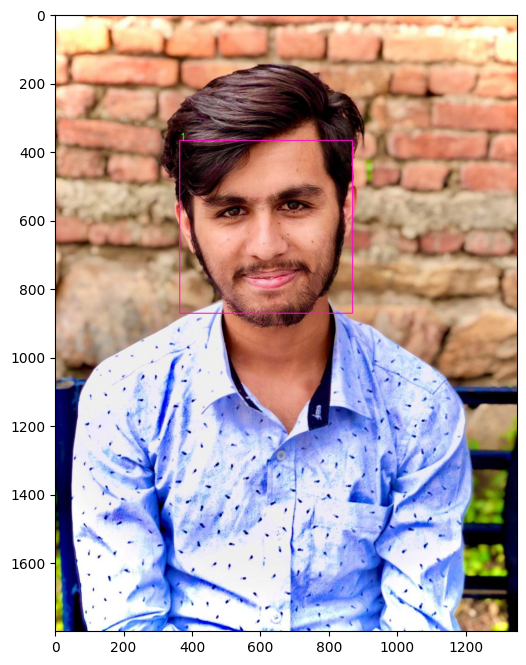

In [ ]:
from io import BytesIO
def age_prediction(img_path):
  test_image = cv2.imread(img_path)
  gray = cv2.cvtColor(test_image,cv2.COLOR_BGR2GRAY)
  face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/dataset_agee/Copy of haarcascade_frontalface_default.xml')
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)

  i = 0
  for (x,y,w,h) in faces:
    i = i+1
    cv2.rectangle(test_image,(x,y),(x+w,y+h),(203,12,255),2)

    img_gray=gray[y:y+h,x:x+w]


    age_image=cv2.resize(img_gray, (200, 200), interpolation = cv2.INTER_AREA)
    age_input = age_image.reshape(-1, 200, 200, 1)
    output_age = age_ranges[np.argmax(age_model.predict(age_input))]


    output_str = str(i) + ":  Age belongs to group of :"+ output_age
    print(output_str)

    col = (0,255,0)

    cv2.putText(test_image, str(i),(x,y),cv2.FONT_HERSHEY_SIMPLEX,1,col,2)

  plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))

age_prediction("/content/drive/MyDrive/dataset_agee/assets/its_me.jpg")